# Environment Setup

In [170]:
import torch
from torch.utils import data
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

##Data

In [171]:
class ExpDataset(Dataset):
  def __init__(self, data):
    assert data.size(dim=1) == 2
    self.data = data

  def __len__(self):
    return self.data.size(dim=0)

  def __getitem__(self, idx):
    return torch.tensor([self.data[idx][0]], dtype=torch.float32), torch.tensor([self.data[idx][1]], dtype=torch.float32)

In [260]:
def plot_data(data):
  df = pd.DataFrame(data=data,columns=['X','Y'])
  sns.scatterplot(data=df,x='X',y='Y',s=1)

def plot_loss(data):
  df = pd.DataFrame(data=data,columns=['epoch','loss'])
  sns.lineplot(data=df,x='epoch',y='loss')

Generate example data

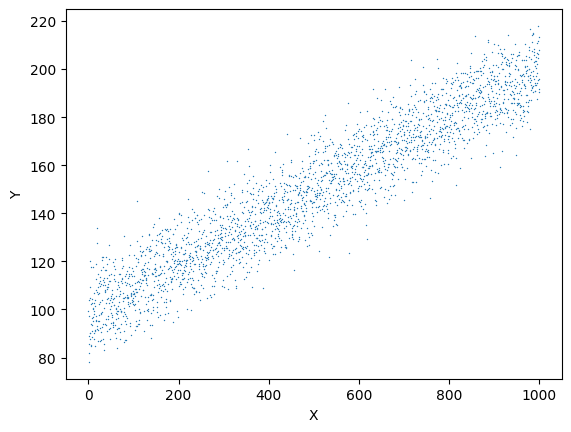

In [173]:
n = 2500
intercept = 100
slope = 0.1
rng = default_rng()
X = np.linspace(start=0,stop=1e3,num=n,dtype='float32')
Y = np.add(slope*X, intercept+rng.normal(loc=0, scale=10, size=n), dtype='float32')

data = np.stack((X,Y), 1)
plot_data(data)

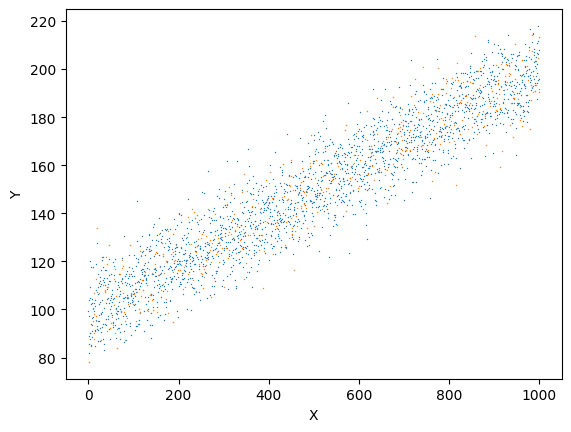

In [174]:
train_data, test_data = train_test_split(data,train_size=0.8)
plot_data(train_data)
plot_data(test_data)

In [175]:
batch_size = 512

training_data = ExpDataset(torch.from_numpy(train_data))
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

testing_data = ExpDataset(torch.from_numpy(test_data))
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

Verify batching

In [176]:
for batch, (X, y) in enumerate(train_dataloader):
  X = X.detach().numpy()
  y = y.detach().numpy()
  print(f"Batch {batch}")
  print(f"X : {X.shape}")
  print(f"y : {y.shape}")
  print("-"*15)

Batch 0
X : (512, 1)
y : (512, 1)
---------------
Batch 1
X : (512, 1)
y : (512, 1)
---------------
Batch 2
X : (512, 1)
y : (512, 1)
---------------
Batch 3
X : (464, 1)
y : (464, 1)
---------------


##Model Definition

In [144]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


Using cpu device


In [177]:
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(1, 1)

  def forward(self, x):
    return self.linear(x)

  def weight(self):
    return self.linear.weight.item()
  
  def bias(self):
    return self.linear.bias.item()


In [267]:
model = LinearRegression().to(device)
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [290]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-3)

Model Training

In [236]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  epoch_loss = []
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    #Forward pass
    pred = model(X)

    # Compute prediction error
    loss = loss_fn(pred, y)
    epoch_loss.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  epoch_loss = np.mean(epoch_loss)
  return epoch_loss

Epoch 1 | loss: 104.9537239074707
Epoch 2 | loss: 104.78496932983398
Epoch 3 | loss: 104.85439682006836
Epoch 4 | loss: 104.85363388061523
Epoch 5 | loss: 105.0832633972168
Epoch 6 | loss: 105.25076866149902
Epoch 7 | loss: 105.0373764038086
Epoch 8 | loss: 104.48224830627441
Epoch 9 | loss: 104.84611129760742
Epoch 10 | loss: 105.04764747619629
Epoch 11 | loss: 105.29891395568848
Epoch 12 | loss: 104.62672996520996
Epoch 13 | loss: 104.70644187927246
Epoch 14 | loss: 105.46725082397461
Epoch 15 | loss: 105.11142158508301
Epoch 16 | loss: 106.02361488342285
Epoch 17 | loss: 105.32842445373535
Epoch 18 | loss: 104.88289833068848
Epoch 19 | loss: 104.82276344299316
Epoch 20 | loss: 104.88167190551758
Epoch 21 | loss: 105.59282493591309
Epoch 22 | loss: 105.71876335144043
Epoch 23 | loss: 104.9114818572998
Epoch 24 | loss: 104.84640121459961
Epoch 25 | loss: 105.17425537109375
Epoch 26 | loss: 104.88273811340332
Epoch 27 | loss: 105.23060417175293
Epoch 28 | loss: 104.7474479675293
Epoch 

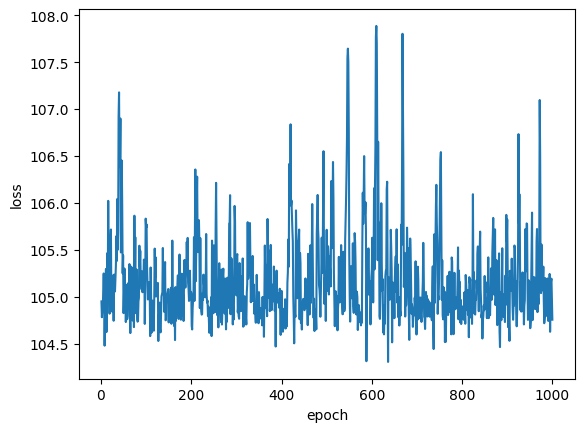

In [292]:
epochs = 1000
loss_curve = []
for t in range(epochs):
  epoch_loss = train(train_dataloader, model, loss_fn, optimizer)
  loss_curve.append([t+1,epoch_loss])
  print(f"Epoch {t+1} | loss: {epoch_loss}")
print("Done!")
loss_curve = np.asarray(loss_curve, dtype=np.float32)
plot_loss(loss_curve)

In [293]:
print(f"Slope: {model.weight()}")
print(f"Intercept: {model.bias()}")

Slope: 0.10150723904371262
Intercept: 98.93216705322266


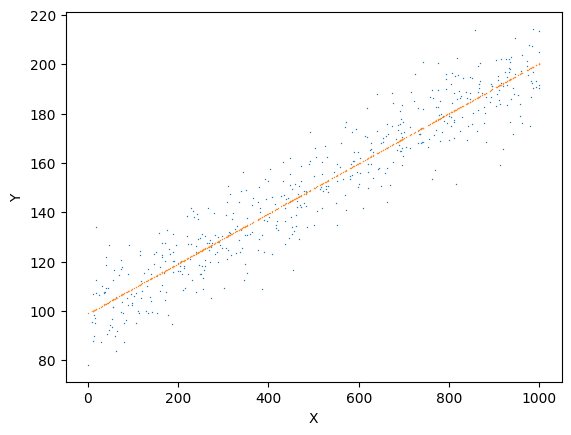

In [294]:
for batch, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    
    #Forward pass
    pred = model(X)
    pred = pred.detach().numpy()

    #Compare
    target_data = torch.stack((X,y),dim=1)
    target_data = torch.squeeze(target_data)
    predicted_data = torch.stack((X,torch.from_numpy(pred)),dim=1)
    predicted_data = torch.squeeze(predicted_data)
    plot_data(target_data)
    plot_data(predicted_data)